<a href="https://colab.research.google.com/github/aspades1/Betting-site-Clustering-Churn--KNN-Classification/blob/main/Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.0.1
!pip install -U imbalanced-learn
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.2 MB 113.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 2.4 MB/s 
     |████████████████████████████████| 199 kB 13.2 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 2.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from functools import reduce

import datetime

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import seaborn as sns

from imblearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import StandardScaler

import sweetviz as sv

In [3]:
from google.colab import files
uploaded = files.upload()

Saving out.zip to out.zip


In [4]:
games = pd.read_csv('out.zip')

Section A: Data Preprocessing ->done in different jupiter notebook



Section B: Data Evaluation 


In [6]:
games.describe()

,Unnamed: 0,UserProfileId,platforms,F,IsFreeSpinID,IsLiveID,Date_y,nuniqueDate,Pt%,age,valpergame,DidBuy
count,622859.000000,6.228590e+05,622859.000000,622859.000000,622859.000000,622859.000000,622859.000000,622859.000000,622859.000000,622859.000000,6.228590e+05,622859.000000
mean,52205.535105,1.150779e+06,6.070401,52.096455,0.497670,0.078782,22.953805,22.953805,-0.047323,29.457636,4.848870e+02,0.885110
std,30527.155033,2.455789e+05,1.972952,43.942557,0.252824,0.129890,13.962791,13.962791,0.521567,15.081167,4.140558e+03,0.318889
min,0.000000,1.040000e+02,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000e+00,0.000000
25%,25952.000000,9.783430e+05,5.000000,20.000000,0.342857,0.000000,12.000000,12.000000,-0.387550,18.000000,2.516063e+01,1.000000
50%,51904.000000,1.157143e+06,6.000000,42.000000,0.482759,0.039216,22.000000,22.000000,-0.000424,31.000000,6.844475e+01,1.000000
75%,77857.000000,1.347481e+06,7.000000,72.000000,0.648649,0.096774,34.000000,34.000000,0.287146,42.000000,2.680503e+02,1.000000
max,121298.000000,1.567122e+06,11.000000,518.000000,1.000000,1.000000,54.000000,54.000000,1.000000,53.000000,1.126668e+06,1.000000


In [7]:
#Generating Sweetviz report
report = sv.analyze(games)
report.show_html("casino_EDA_report.html") # specify a name for the report

                                             |          | [  0%]   00:00 -> (? left)

Report casino_EDA_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Text(0.5, 1.0, 'Correlation with Churn Rate \n')

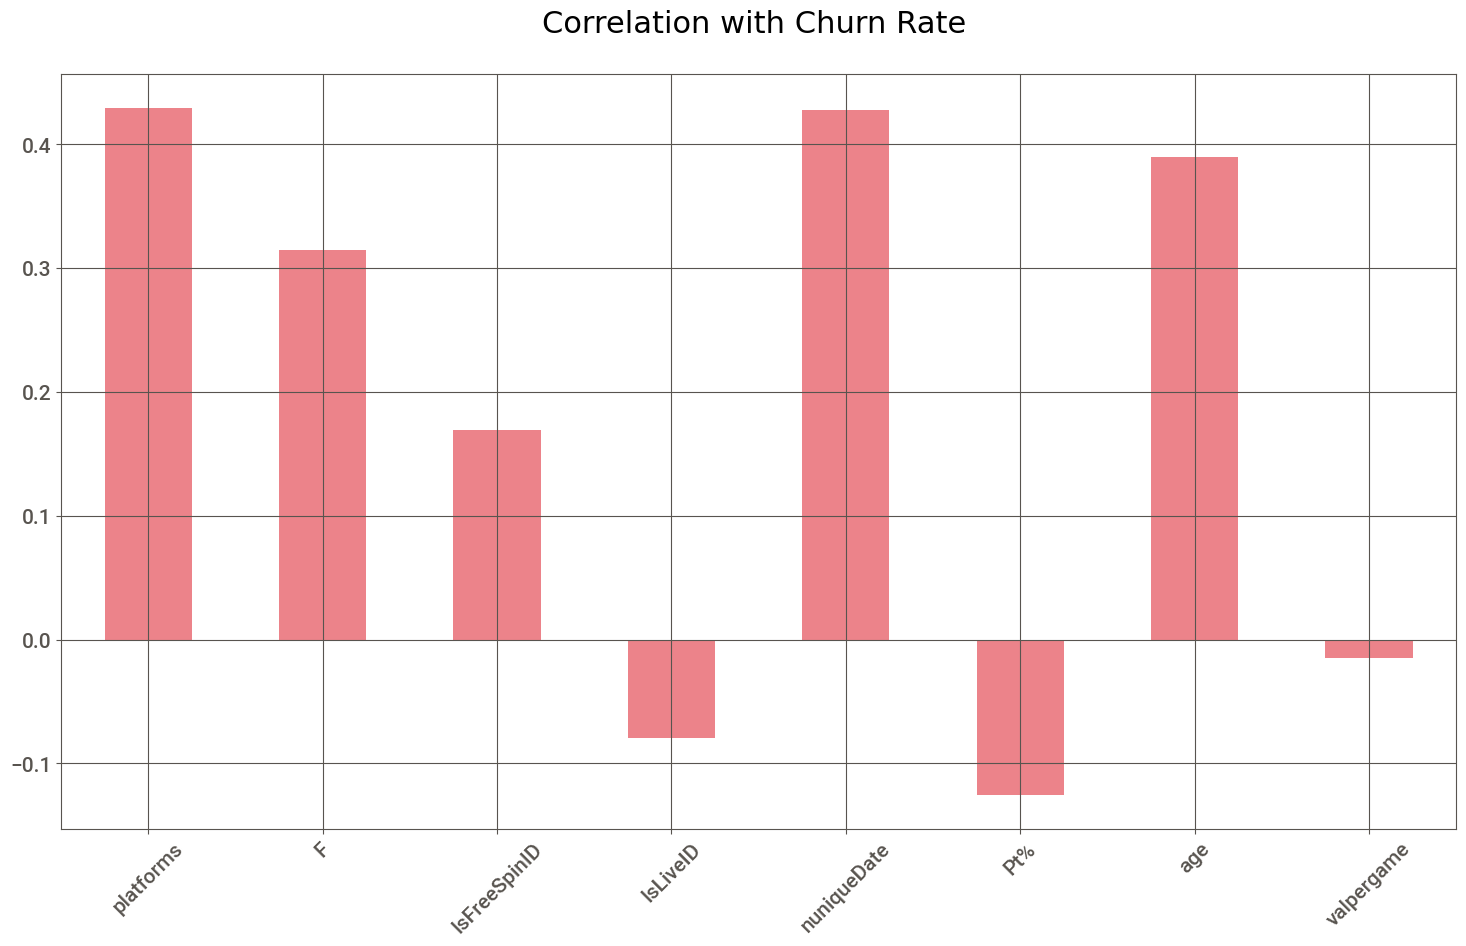

In [8]:
#Plot positive & negative correlations:
correlations = games[['platforms','F','IsFreeSpinID',	\
                      'IsLiveID','nuniqueDate','Pt%','age','valpergame']].corrwith(games.DidBuy)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


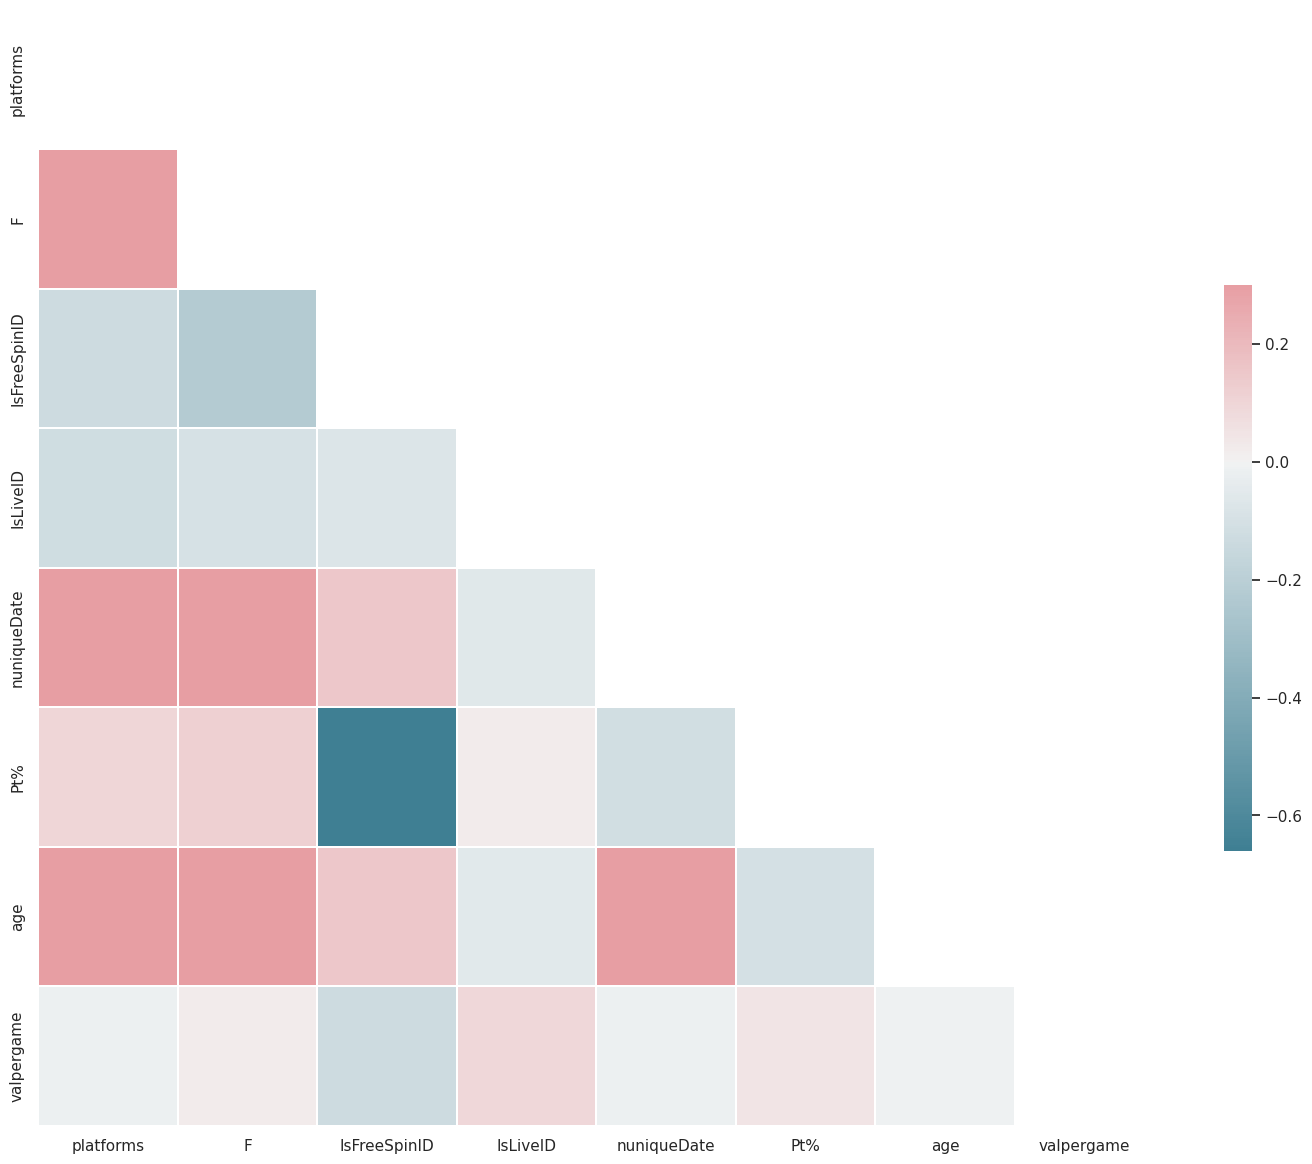

In [9]:
#Plot Correlation Matrix of all independent variables

sns.set(style="white")
corr = games[['platforms','F','IsFreeSpinID',	\
                      'IsLiveID','nuniqueDate','Pt%','age','valpergame']].corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Check Multicollinearity using VIF: Unlike Correlation matrix, VIF determines the strength of the correlation of a variable with a group of other independent variables in a dataset. VIF starts usually at 1 and anywhere exceeding 10 indicates high multicollinearity between the independent variables.

def calc_vif(X):
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return(vif)
dataset2 = games[['platforms','F','IsFreeSpinID',	\
                      'IsLiveID','nuniqueDate','Pt%','age','valpergame']]
calc_vif(dataset2)



,variables,VIF
0,platforms,11.972961
1,F,11.045145
2,IsFreeSpinID,7.372826
3,IsLiveID,1.322359
4,nuniqueDate,26.922868
5,Pt%,1.604445
6,age,17.666863
7,valpergame,1.032374


Text(0.5, 1.0, 'Collinearity of unique Dates and age of player profile \n')

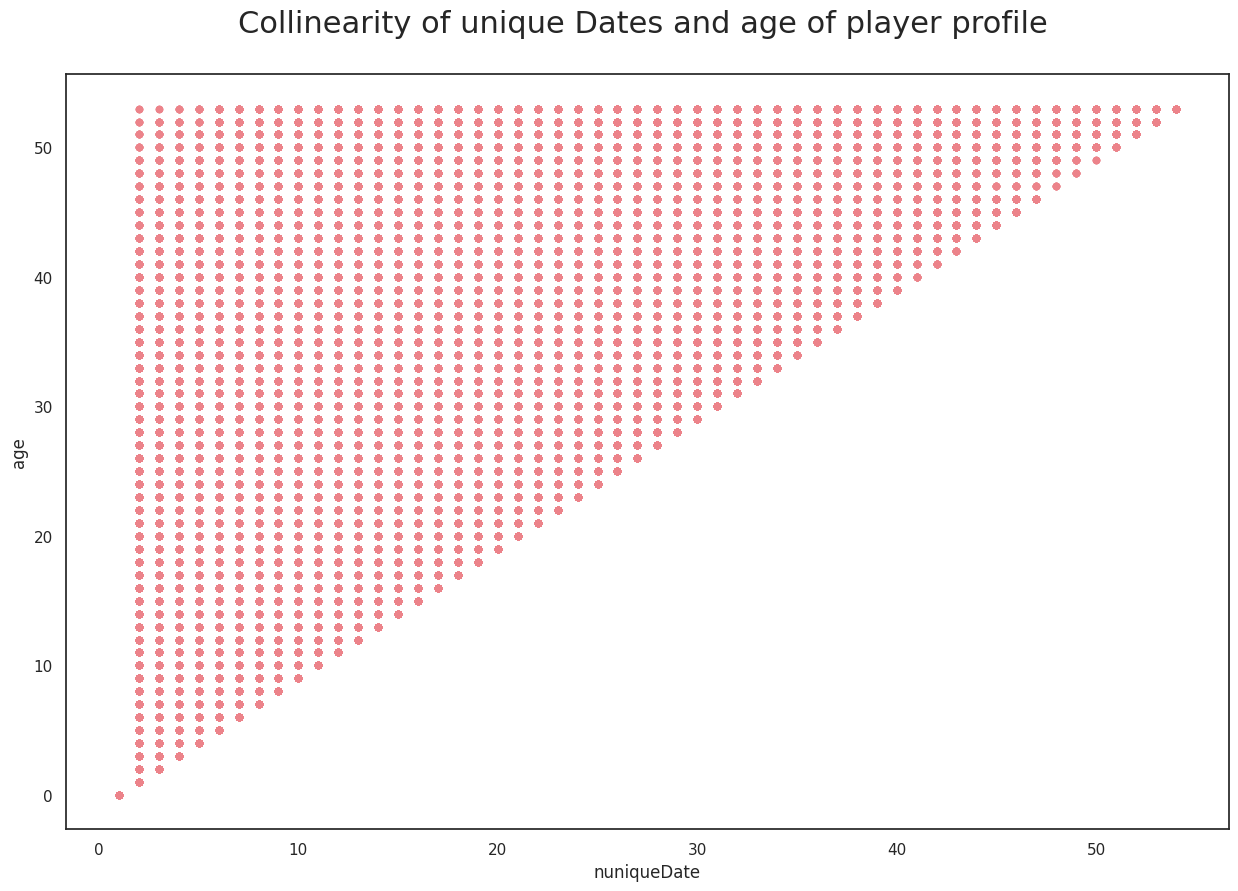

In [11]:
#Check colinearity:   
games[['nuniqueDate', 'age']].plot.scatter(\
  figsize = (15, 10), \
  x ='nuniqueDate',y='age', color =  '#ec838a')
plt.title('Collinearity of unique Dates and age of player profile \n',
horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

In [12]:
#Dropping:
dataset3 = dataset2.drop(columns = 'nuniqueDate')
#Revalidate Colinearity:
calc_vif(dataset3)

,variables,VIF
0,platforms,11.811750
1,F,6.149932
2,IsFreeSpinID,6.868809
3,IsLiveID,1.322179
4,Pt%,1.593060
5,age,9.535993
6,valpergame,1.031907


In [13]:
#Applying changes in the main dataset:
games = games.drop(columns = 'nuniqueDate')


Section C: Model Selection



Time to split dataset and try models. As there is a time constraint in this project we will start with random forest and move on from there based on the resulst. We will not do an extensive search for many classidfiers

In [14]:
X = games[['platforms', 'F', 'IsFreeSpinID','IsLiveID','Pt%','valpergame','age']]
y = games[['DidBuy']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True,stratify=y)

In [15]:
rf = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)

In [16]:
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)

print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Train Acc: 0.9969, Test Acc: 0.9093


In [17]:
#print(classification_report(predictions.true, predictions.preds))
print(classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.66      0.44      0.53     14312
         1.0       0.93      0.97      0.95    110260

    accuracy                           0.91    124572
   macro avg       0.79      0.70      0.74    124572
weighted avg       0.90      0.91      0.90    124572



In [18]:
games.DidBuy.value_counts()

1.0    551299
0.0     71560
Name: DidBuy, dtype: int64

We identify the reason for such a low performing model (recal of class 0 is <.5) as the imbalance of our dataset. We will use BalancedRandomForestClassifier in our next step.

In [19]:
brf = BalancedRandomForestClassifier()
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.40      0.87      0.55     14312
         1.0       0.98      0.83      0.90    110260

    accuracy                           0.84    124572
   macro avg       0.69      0.85      0.72    124572
weighted avg       0.91      0.84      0.86    124572



We see a significant betterment of our results in terms of recall of class 0,along  with a decrease in accuracy. As our goal was to correctly identify the players who would churn so we could format strategies to increase client retention, that is acceptable.

Section D: Model Evaluation

In [21]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(brf, X, y, scoring="accuracy", cv=cv)

NameError: ignored

In [23]:
# summarize performance
print('Mean accuracy: %.3f'  % np.mean(scores))
print('stddev accuracy: %.3f'% np.std(scores))

Mean accuracy: 0.836
stddev accuracy: 0.001


In [24]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(brf, X, y, scoring="roc_auc", cv=cv)

In [25]:
# summarize performance
print('Mean roc_auc: %.3f' % np.mean(scores))
print('stddev roc_auc: %.3f' % np.std(scores))

Mean roc_auc: 0.921
stddev roc_auc: 0.001


In [26]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(brf, X, y, scoring="f1", cv=cv)
# summarize performance
print('Mean f1: %.3f' % np.mean(scores))
print('stddev f1: %.3f' % np.std(scores))

Mean f1: 0.900
stddev f1: 0.001


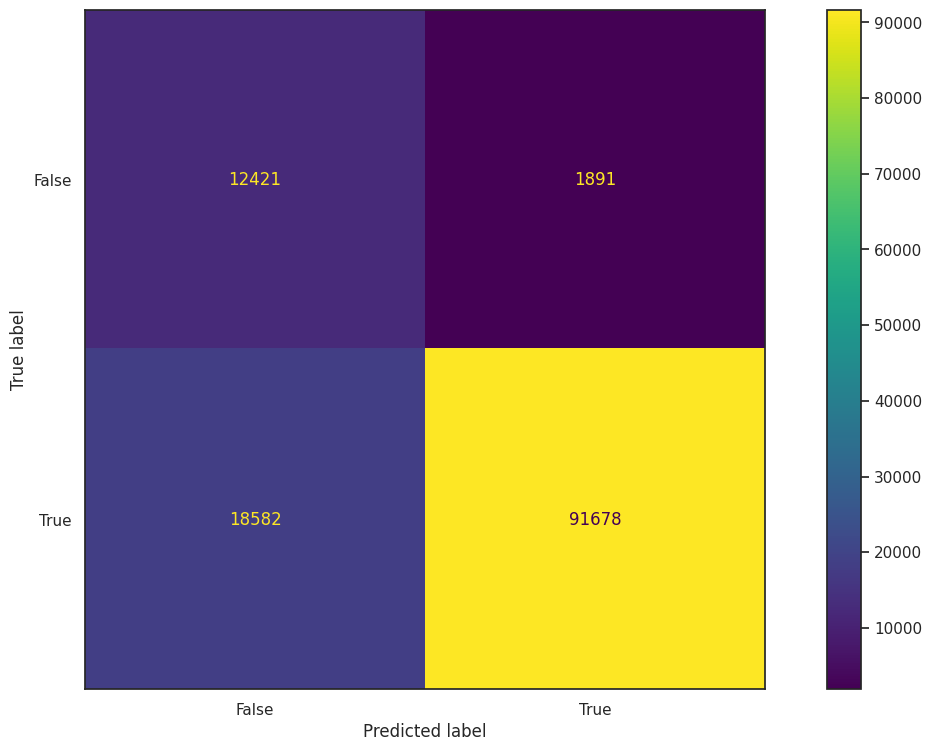

In [27]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [28]:
#Recall = TruePositives / (TruePositives + FalseNegatives)

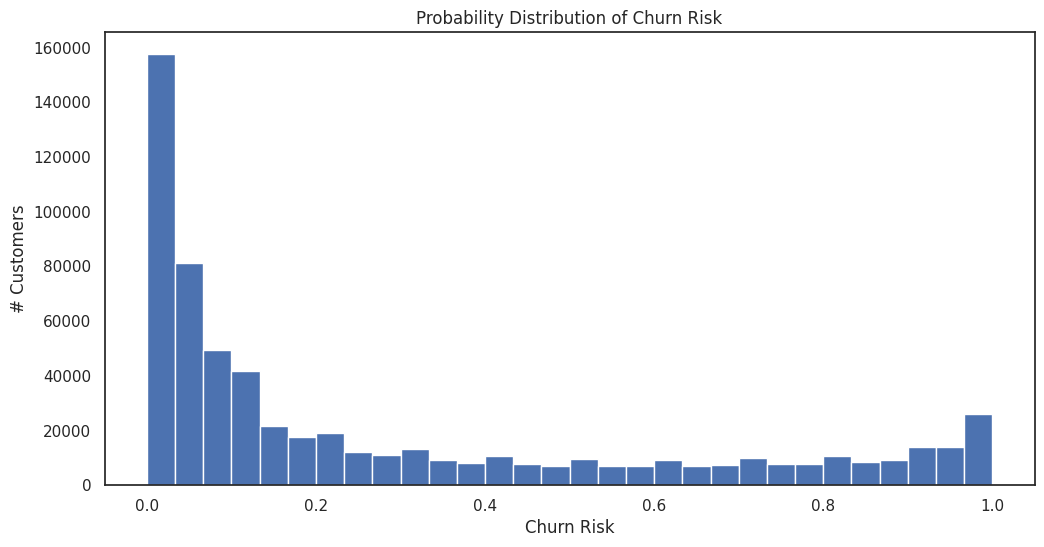

In [29]:
probs = brf.predict_proba(X)[:, 0]
probs

plt.figure(figsize=(12, 6))
# matplotlib histogram
plt.hist(probs, bins = int(180/6))

plt.title('Probability Distribution of Churn Risk')
plt.xlabel('Churn Risk')
plt.ylabel('# Customers')
plt.show()



Section E: Model Improvement





In [30]:
from sklearn.model_selection import GridSearchCV

In [37]:
# GridSearchCV:
parameters={'n_estimators': [20,40,60,80,100], 'criterion': ['gini', 'entropy'],'max_features':['auto', 'sqrt', 'log2']}
# Combine Parameters
gd_classifier = GridSearchCV(estimator = brf,param_grid = parameters,scoring = 'accuracy',cv = 10,n_jobs = -1)

gd_classifier.fit(X_train, y_train)

_best_recall = gd_classifier.best_score_
_best_parameters = gd_classifier.best_params_
_best_recall, _best_parameters

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(0.8364838008089295,
 {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100})

In [35]:
brf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'replacement', 'sampling_strategy', 'verbose', 'warm_start'])

In [22]:
#Resplit the dataset but make X keep userid:
X = games[['UserProfileId','platforms', 'F', 'IsFreeSpinID','IsLiveID','Pt%','valpergame','age']]
y = games[['DidBuy']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True,stratify=y)

train_identity = X_train['UserProfileId']
X_train = X_train.drop(columns = ['UserProfileId'])
test_identity = X_test['UserProfileId']
X_test = X_test.drop(columns = ['UserProfileId'])

In [23]:
brf = BalancedRandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators= 100)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.40      0.87      0.55     14312
         1.0       0.98      0.83      0.90    110260

    accuracy                           0.84    124572
   macro avg       0.69      0.85      0.72    124572
weighted avg       0.91      0.84      0.86    124572



Section F: Future Predictions

In [67]:
test_identity = pd.DataFrame(test_identity).reset_index()

In [68]:
test_y = pd.DataFrame(y_test)

In [69]:
test_y.rename(columns={0: 'Churn=0'}, inplace=True)

In [70]:
final_results = pd.concat([test_identity, test_y], axis = 1)

In [71]:
final_results['predictions'] = y_pred

In [72]:
final_results

,level_0,index,UserProfileId,Churn=0,predictions
0,0,13526,831348,1.0,0.0
1,1,571286,1154517,0.0,0.0
2,2,543041,949173,1.0,1.0
3,3,64928,1196413,1.0,1.0
4,4,551877,1008813,1.0,1.0
...,...,...,...,...,...
124567,124567,233098,860399,1.0,1.0
124568,124568,161902,1086456,1.0,0.0
124569,124569,414388,1529497,1.0,1.0
124570,124570,14686,850403,1.0,1.0


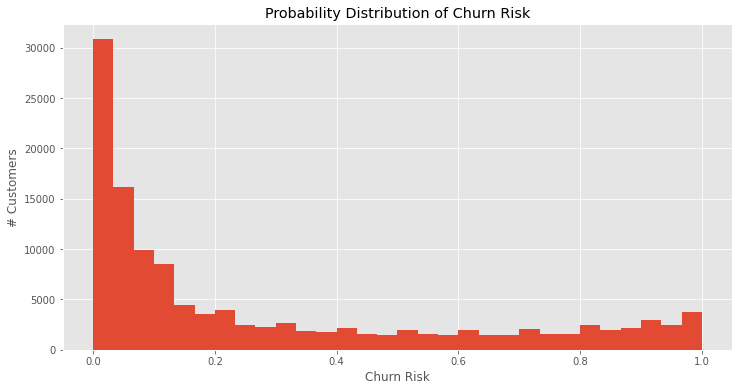

In [73]:
y_pred_probs = brf.predict_proba(X_test)[:, 0]
# matplotlib histogram
plt.figure(figsize=(12, 6))
plt.hist(y_pred_probs, bins = int(180/6))
plt.title('Probability Distribution of Churn Risk')
plt.xlabel('Churn Risk')
plt.ylabel('# Customers')
plt.show()

The graph shows histogram of churn(=0). The majority of clients have a probability of 0% to churn. A few have >80% to churn. The interesting is that there is a large number in between for which we could focus our analysis.

Step 20: Format Final Results: Unpredictability and risk are the close companions of any predictive models. Therefore in the real world, its always a good practice to build a propensity score besides an absolute predicted outcome. Instead of just retrieving a binary estimated target outcome (0 or 1), every ‘ID’ could get an additional layer of propensity score highlighting their percentage of probability to take the target action. Since our model uses decision trees(random forst), the predicted class probabilities of an input sample is computed as the mean predicted class probabilities of the trees in the forest.

In [76]:
final_results["propensity_to_churn(%)"] = y_pred_probs
final_results["propensity_to_churn(%)"] = final_results["propensity_to_churn(%)"]*100
final_results["propensity_to_churn(%)"]=final_results["propensity_to_churn(%)"].round(2)
final_results = final_results[['UserProfileId', 'Churn=0', 'predictions', 'propensity_to_churn(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [75]:
final_results

,UserProfileId,Churn=0,predictions,propensity_to_churn(%),Ranking
0,831348,1.0,0.0,63.0,2
1,1154517,0.0,0.0,64.0,2
2,949173,1.0,1.0,0.0,10
3,1196413,1.0,1.0,3.0,9
4,1008813,1.0,1.0,45.0,3
...,...,...,...,...,...
124567,860399,1.0,1.0,1.0,9
124568,1086456,1.0,0.0,66.0,2
124569,1529497,1.0,1.0,33.0,4
124570,850403,1.0,1.0,10.0,6


It would be interesting to do an analysis on the customers behaviour based on the expected probability.